In [1]:
import pandas as pd
import numpy as np
import torch

mu_vec = pd.read_csv('data/mu_vec.csv', index_col=0).values
covariances_mtx = pd.read_csv('data/covariance_mtx.csv', index_col=0).values

mu_vec = mu_vec.flatten()

In [2]:
def compute_optimal_portfolio(mu0, mu_vec, covariances_mtx, print_debug_info=False):
    # make sure that mu0 is an attainable expected return
    if mu0 > max(mu_vec):
        print(f'mu0 = {mu0} is too large. The maximum possible return is {max(mu_vec)}')
        return None
    

    # convert the input data to torch tensors
    mu_vec = torch.tensor(mu_vec, dtype=torch.float32)
    covariances_mtx = torch.tensor(covariances_mtx, dtype=torch.float32)


    # define the loss function
    def loss_fn(x, mu0):
        calculated_variance = torch.matmul(x, torch.matmul(covariances_mtx, x))
        calculated_return = torch.dot(x, mu_vec)

        # expected_return >= mu0 --> 0 >= mu0 - expected_return --> mu0 - expected_return <= 0
        expected_return_penalty = torch.relu(mu0 - calculated_return)**2
        # x_i >= 0
        short_selling_penalty = torch.sum(torch.relu(-x)**2)
        # sum(x) = 1
        no_leverage_penalty = (torch.sum(x) - 1)**2

        loss = calculated_variance + 1e3*expected_return_penalty + 1e3*short_selling_penalty + 1e3*no_leverage_penalty

        return loss
    

    # pick an arbitrary initial value for x
    # NOTE: I just picked 0.2 for each asset which happens to satisfy one of the constraints, but this is not needed!
    x = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.2], requires_grad=True)

    optimizer = torch.optim.Adam([x], lr=0.001)

    # run the optimization loop
    for i in range(10000):
        # Compute the loss
        loss = loss_fn(x, mu0)
        
        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()
        
        # Compute the derivatives of the loss w.r.t. parameters
        loss.backward()
        
        # Step the optimizer - update the parameters
        optimizer.step()

        # Print some information
        if i % 100 == 0 and print_debug_info == True:
            print(f'Iteration {i}')
            print(f'\tx = {x.detach().numpy()}')
            print(f'\tloss = {loss.item()}')
    
    return x.detach().numpy()


x = compute_optimal_portfolio(0.025, mu_vec, covariances_mtx, print_debug_info=True)
x

Iteration 0
	x = [0.201 0.199 0.201 0.201 0.201]
	loss = 0.27517586946487427
Iteration 100
	x = [0.22490504 0.15580215 0.18961774 0.20109919 0.22871101]
	loss = 0.20952335000038147
Iteration 200
	x = [0.25960356 0.09855799 0.1724356  0.20121855 0.26829106]
	loss = 0.1348286271095276
Iteration 300
	x = [0.2940211  0.04371219 0.1542986  0.20086855 0.30718103]
	loss = 0.07799512892961502
Iteration 400
	x = [ 3.2343760e-01 -2.1503889e-05  1.3695458e-01  1.9941646e-01
  3.4031522e-01]
	loss = 0.042691927403211594
Iteration 500
	x = [ 3.40894938e-01 -1.86419435e-04  1.10711075e-01  1.87236935e-01
  3.61425191e-01]
	loss = 0.03348079323768616
Iteration 600
	x = [ 3.5805205e-01 -1.6290548e-04  8.4936887e-02  1.7516401e-01
  3.8207993e-01]
	loss = 0.02561964839696884
Iteration 700
	x = [ 3.7444401e-01 -1.3855826e-04  6.0430396e-02  1.6362177e-01
  4.0170220e-01]
	loss = 0.01921720989048481
Iteration 800
	x = [ 3.8969019e-01 -1.1601788e-04  3.7749749e-02  1.5289620e-01
  4.1983014e-01]
	loss = 0

array([ 5.0145543e-01, -2.9236222e-05, -5.2156702e-06,  1.0431964e-05,
        4.9852353e-01], dtype=float32)

In [3]:
def expected_return(x_vec, mu_vec):
    return np.dot(x_vec, mu_vec)

def variance(x_vec, covariances_mtx):
    return np.dot(x_vec, np.dot(covariances_mtx, x_vec))

expected_return(x, mu_vec), variance(x, covariances_mtx)

# (array([ 0.67012059, -3.00975761,  0.54559178,  2.10070076,  0.25337797]),
#  0.1,
#  0.012265101382521315)

(0.024660344213063682, 0.002786118928825039)

In [4]:
from tqdm import tqdm

mu0_values = np.linspace(0, 0.025, 10)

# compute the optimal portfolios for each mu0 value
optimal_portfolios = []
for mu0_val in tqdm(mu0_values):
    x = compute_optimal_portfolio(mu0_val, mu_vec, covariances_mtx)
    optimal_portfolios.append(x)

100%|██████████| 10/10 [01:34<00:00,  9.44s/it]


In [5]:
for i in range(len(mu0_values)):
    mu0_val = mu0_values[i]
    expected_return_val = expected_return(optimal_portfolios[i], mu_vec)
    variance_val = variance(optimal_portfolios[i], covariances_mtx)
    print(f'mu0 = {mu0_val:.5f}, expected return = {expected_return_val:.5f}, variance = {variance_val:.5f}')

mu0 = 0.00000, expected return = 0.00671, variance = 0.00054
mu0 = 0.00278, expected return = 0.00671, variance = 0.00054
mu0 = 0.00556, expected return = 0.00671, variance = 0.00054
mu0 = 0.00833, expected return = 0.00831, variance = 0.00060
mu0 = 0.01111, expected return = 0.01109, variance = 0.00071
mu0 = 0.01389, expected return = 0.01386, variance = 0.00086
mu0 = 0.01667, expected return = 0.01663, variance = 0.00105
mu0 = 0.01944, expected return = 0.01935, variance = 0.00148
mu0 = 0.02222, expected return = 0.02210, variance = 0.00206
mu0 = 0.02500, expected return = 0.02466, variance = 0.00279


Text(0, 0.5, 'Minimum weekly variance ($\\sigma^2$)')

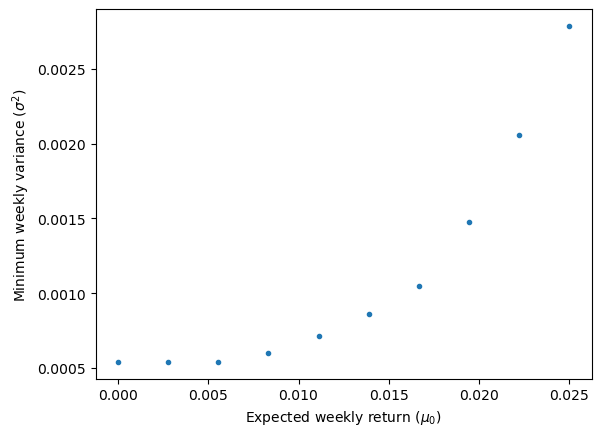

In [6]:
import matplotlib.pyplot as plt

portfolio_variances = [variance(optimal_portfolio, covariances_mtx) for optimal_portfolio in optimal_portfolios]

plt.plot(mu0_values, portfolio_variances, '.')
plt.xlabel('Expected weekly return ($\mu_0$)')
plt.ylabel('Minimum weekly variance ($\sigma^2$)')

In [7]:
tickers = ["NVDA", "JPM", "LLY", "GE", "GBTC"]

data = pd.DataFrame(optimal_portfolios, columns=tickers, index=mu0_values.round(5))

data

,NVDA,JPM,LLY,GE,GBTC
0.00000,0.191648,0.220792,0.225056,0.213643,0.148874
0.00278,0.191648,0.220792,0.225056,0.213643,0.148874
0.00556,0.191648,0.220792,0.225056,0.213643,0.148874
0.00833,0.210327,0.186363,0.218942,0.215613,0.168744
0.01111,0.243370,0.124290,0.211510,0.221890,0.199008
0.01389,0.276627,0.063761,0.201958,0.226883,0.230844
0.01667,0.310608,0.004361,0.190631,0.231173,0.263258
0.01944,0.372863,0.000059,0.104362,0.191183,0.331686
0.02222,0.439065,0.000015,0.011211,0.146434,0.403017
0.02500,0.501455,-0.000029,-0.000005,0.000010,0.498524


Text(0.5, 1.0, 'Portfolios for Increasing Weekly Returns')

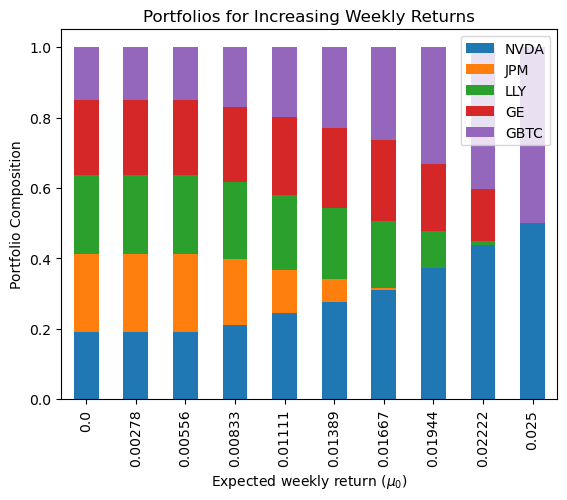

In [8]:
data.plot.bar(stacked=True)
plt.xlabel('Expected weekly return ($\mu_0$)')
plt.ylabel('Portfolio Composition')
plt.title('Portfolios for Increasing Weekly Returns')